In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
from heatmap import HeatMap as hm
import h5py
import matplotlib.animation as animation
from simulation import individual_simulation as sim_

In [17]:
def cost_col(path, name, range_):
    cost = []
    time = []
    total_slices = 0
    num_cost = []
    data = h5py.File(path + name + f"{3}.h5", "r")
    target = data["target"][:]
    # First pass: Collect cost and calculate total slices in advance
    for i in range(range_[0], range_[1]):
        data = h5py.File(path + name + f"{i}.h5", "r")
        time.extend(data["time"])
        cost.extend(list(data["cost"]))
        num_cost.append(len(list(data["cost"])))
        data.close()

    # Preallocate the results array based on the total number of slices (z-axis)
    res_ = np.zeros((len(cost), 100, 100))

    # Second pass: Fill the results array
    inx = 0
    h = 0
    for j in range(range_[0], range_[1]):
        data = h5py.File(path + name + f"{j}.h5", "r")
        _, y, x = data["results"].shape
        res_[inx:inx + num_cost[h], :, :] = data["results"][:num_cost[h], :, :]  # Add data slice by slice
        inx += num_cost[h]  # Update index for next file
        h += 1
        data.close()

    return cost, res_, target, time   

In [63]:
path = "/home/samani/Documents/projects/master_project/model/results/model_2/"
file = h5py.File(path+"datasets15.h5")
ind = file["ind"][:]
print(file.keys())

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/home/samani/Documents/projects/master_project/model/results/model_2/datasets15.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [70]:
path = "/home/samani/Documents/projects/master_project/model/results/model_2/"
name = "datasets"
data, res_, target, time = cost_col(path=path, name=name, range_=(2, 16))

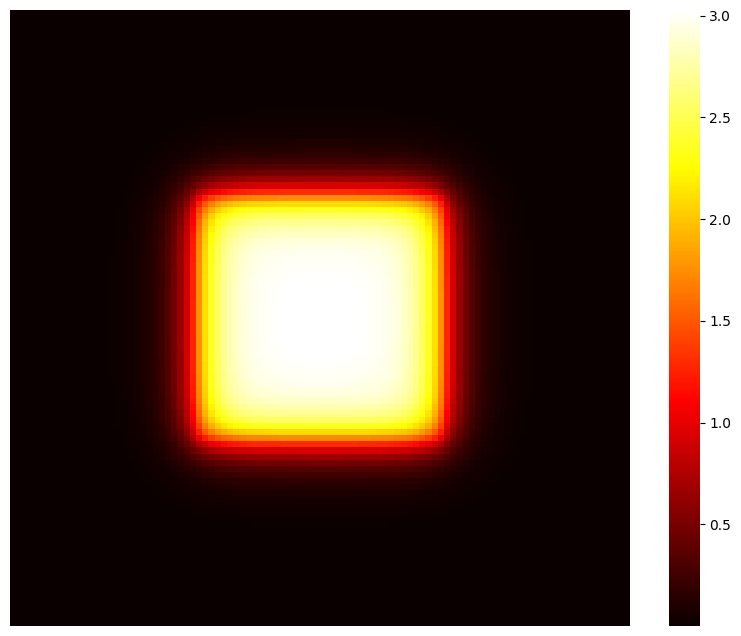

<Figure size 640x480 with 0 Axes>

In [18]:
plt.figure(figsize=(10, 8))
sns.heatmap(target, cmap="hot")
plt.axis('off')
plt.savefig('/home/samani/Documents/sim/hm/target')
plt.show()

plt.clf()

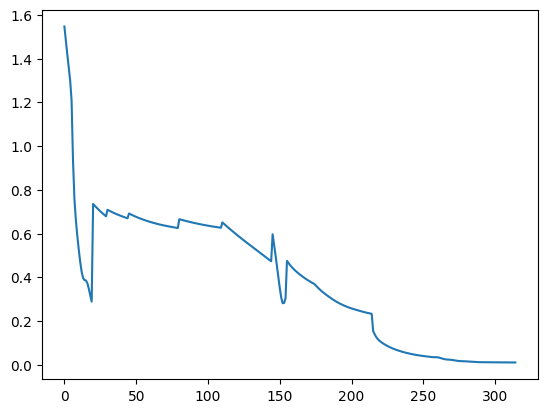

[0.23870131788900545, 0.23714445816096277, 0.23562167491164723, 0.23415399091157219, 0.23275883710177075, 0.1542893863711961, 0.14029914340531827, 0.1280126294647366, 0.11884632865284506, 0.11201524491936835, 0.10641827564533876, 0.10147841119521366, 0.09698023803395697, 0.09287871100359747, 0.08905120143707197, 0.08546562635669824, 0.08213349962557334, 0.07903443660519562, 0.07605306776521846, 0.07332929413034296]


In [13]:
plt.plot(data)
plt.show()
print(data[210:230])

In [44]:
c1 = data[:5]
c2 = data[30:130]
c3 = data[160:170]
c4 = data[180:]
print(len(c2))
c_final = c1 + c2 + c3 + c4
print(len(c_final))

100
250


In [45]:
y_hat = np.zeros((250, 100, 100))
y_hat[:5, :, :] = res_[:5, :, :]
y_hat[5:105, :, :] = res_[30:130, :, :]
y_hat[105:115, :, :] = res_[160:170 , :, :]
y_hat[115:, :, :] = res_[180:, :, :]

In [46]:
print(y_hat.shape)

(250, 100, 100)


In [47]:
def generate_heatmap_video(results, cmap='magma', save_path='heatmap_video.mp4', dpi=300, fps=10, bitrate=2000):
    # Results is a 3D matrix: (iterations, y, x)
    iterations, y, x = results.shape

    # Create a figure and axis for plotting
    fig, ax = plt.subplots(figsize=(10, 8), dpi=dpi)  # Adjust figure size and dpi for higher resolution
    cax = ax.imshow(results[0, :, :], cmap=cmap, vmin=np.min(results), vmax=np.max(results))
    fig.colorbar(cax)

    # Remove axis ticks (labels)
    ax.set_xticks([])
    ax.set_yticks([])

    def update(i):
        cax.set_data(results[i, :, :])
        ax.set_title(f"Iteration {i}")

    # Create the animation
    ani = animation.FuncAnimation(fig, update, frames=iterations, repeat=False)

    # Save the animation as a video file with higher quality settings
    ani.save(save_path, writer='ffmpeg', fps=fps, bitrate=bitrate, dpi=dpi)

    plt.close()

In [48]:
generate_heatmap_video(y_hat, cmap='hot', save_path='optimization_progress2.mp4')

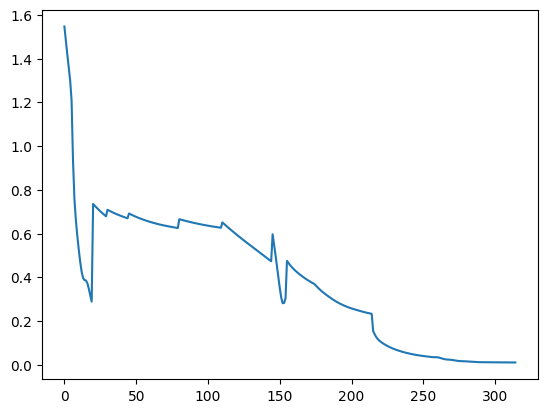

In [49]:
plt.plot(data)
plt.show()

In [50]:
t1 = data[:7]
t2 = data[20:140]
t3 = data[160:293]
print(t1)
costs = t1+t2+t3

[1.5471842365669262, 1.483039104491199, 1.42071453311054, 1.3616776940894524, 1.3012876122494466, 1.2097207621993395, 0.9337914249995449]


[]

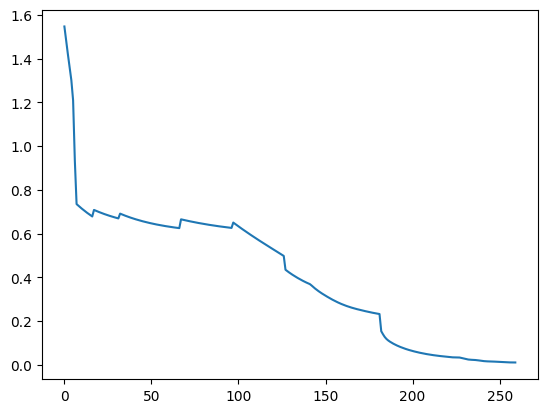

In [51]:
plt.plot(costs)
plt.plot()

In [52]:
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Smoothing the data with a window size of 5
sm_ = moving_average(costs, window_size=10)

In [53]:
cost_ = sm_[:-1]

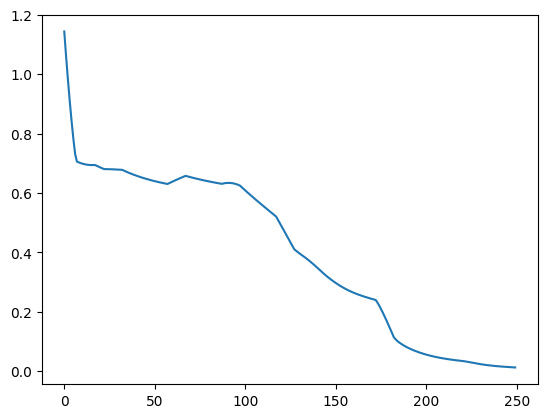

250


In [54]:
plt.plot(cost_)
plt.show()
print(len(cost_))

In [7]:
"""

def generate_cost_animation(costs, save_path='cost_progression.mp4', dpi=300, fps=10, bitrate=2000):
    # Create a figure and axis for plotting
    fig, ax = plt.subplots(figsize=(10, 6), dpi=dpi)
    ax.set_xlim(0, len(costs))  # X-axis is the number of iterations
    ax.set_ylim(min(costs), max(costs))  # Y-axis is the range of cost values
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Cost")

    # Initialize an empty line and a point for the head of the line
    line, = ax.plot([], [], lw=4, color='red')  # Thicker red line
    point = ax.plot([], [], marker='o', color='red', markersize=10)[0]  # Circle at the end of the line

    # Title to update during the animation
    title = ax.text(0.5, 1.05, '', transform=ax.transAxes, ha="center", fontsize=16)

    # Function to initialize the animation
    def init():
        line.set_data([], [])
        point.set_data([], [])
        title.set_text('')
        return line, point, title

    # Function to update the animation at each frame
    def update(i):
        x = np.arange(i + 1)  # Iterations
        y = costs[:i + 1]  # Costs up to iteration i
        line.set_data(x, y)
        point.set_data(i, costs[i])  # Update the point to the current position
        title.set_text(f"Cost Progression - Iteration {i}")
        return line, point, title

    # Create the animation
    ani = animation.FuncAnimation(fig, update, frames=len(costs), init_func=init, blit=True, repeat=False)

    # Save the animation as a video file with higher quality settings
    ani.save(save_path, writer='ffmpeg', fps=fps, bitrate=bitrate)

    plt.close()
"""

In [9]:
def generate_cost_accuracy_animation(costs, accuracies, save_path='cost_accuracy_progression.gif', dpi=300, fps=10, bitrate=2000):
    
    fig, ax = plt.subplots(figsize=(16, 6), dpi=dpi)
    ax.set_xlim(-5, len(costs)+5)  
    ax.set_ylim(-.1, 1.2)
    ax.set_xlabel("Iterations")
    ax.set_ylabel("Values")
    
    cost_line, = ax.plot([], [], lw=4, color='red', label="Cost") 
    accuracy_line, = ax.plot([], [], lw=4, color='blue', label="Accuracy")

    cost_point = ax.plot([], [], marker='o', color='red', markersize=10)[0]  
    accuracy_point = ax.plot([], [], marker='o', color='blue', markersize=10)[0]  

    title = ax.text(0.5, 1.05, '', transform=ax.transAxes, ha="center", fontsize=16)
    ax.legend(loc='upper right')

    def init():
        cost_line.set_data([], [])
        accuracy_line.set_data([], [])
        cost_point.set_data([], [])
        accuracy_point.set_data([], [])
        title.set_text('')
        return cost_line, accuracy_line, cost_point, accuracy_point, title

    def update(i):
        x = np.arange(i + 1) 
        cost_y = costs[:i + 1]  
        accuracy_y = accuracies[:i + 1] 
        cost_line.set_data(x, cost_y)
        accuracy_line.set_data(x, accuracy_y)
        cost_point.set_data(i, costs[i]) 
        accuracy_point.set_data(i, accuracies[i]) 
        title.set_text(f"Cost & Accuracy - {i}")
        return cost_line, accuracy_line, cost_point, accuracy_point, title

    ani = animation.FuncAnimation(fig, update, frames=len(costs), init_func=init, blit=True, repeat=False)
    ani.save(save_path.replace('.mp4', '.gif'), writer='pillow', fps=fps)
    plt.close()

In [10]:
file_path = r"C:\Users\yda2\Downloads\projects\master_project\model\results\model_2\final\data.h5"
hh = h5py.File(file_path, "r")

In [11]:
costs = list(hh["cost"][:])
accuracies = list(hh["accuracy"][:]/100)

In [12]:
generate_cost_accuracy_animation(costs, accuracies, save_path='cost_accuracy_progression1_.gif')

C:\Users\yda2\AppData\Local\Temp\ipykernel_1972\16991556.py:32: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  cost_point.set_data(i, costs[i])
C:\Users\yda2\AppData\Local\Temp\ipykernel_1972\16991556.py:33: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  accuracy_point.set_data(i, accuracies[i])


In [88]:
print(cost_.shape)

(250,)


In [71]:
print(time)

[1950.084363937378, 1727222922.983993, 1727224850.1561196, 1727226769.0231082, 1930.4774236679077, 1727243065.7290616, 1903.2715594768524, 1727250641.539282, 1727252544.3889277, 2036.0549175739288, 1727258147.5558736, 1727260083.497824, 1727261995.1342554, 1727263923.0233963, 1727265849.940525, 1727267772.860787, 1974.4073343276978, 1727272931.9566767, 1727275208.6547256, 1727277458.8365686, 1727279490.289722, 1727281643.9755101, 1975.0511636734009, 1727287398.171686, 1727289337.0858026, 1727291257.815351, 1727293160.5686615, 1727295051.0973675, 1727296948.1797738, 2063.454127550125, 1727303898.9526157, 1638.218118429184, 1727307790.314476, 1727309413.162179, 1727311016.789781, 1648.7290532588959, 1727315823.1236527, 1727317440.1658072, 1727319046.9852414, 1727320648.9373655, 1727322258.4327013, 1727323865.7536204, 1727325473.4037485, 1646.491014957428, 1727332598.4020345, 1727334238.271786, 1727335872.079433, 1727337502.8868048, 1727339126.6697428, 1727340755.9056554, 1727342385.50521

In [75]:
test_, d = sim_(ind)

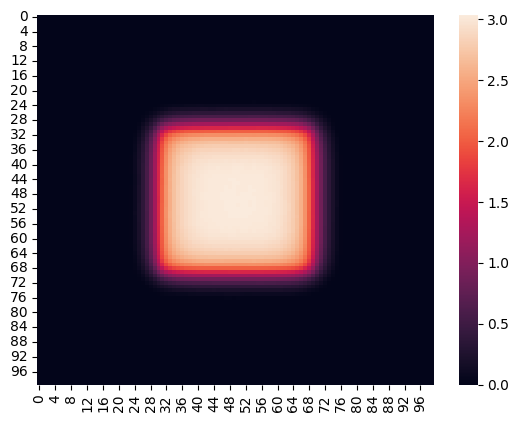

In [76]:
sns.heatmap(test_)
plt.show()

In [93]:
with h5py.File("/home/samani/data.h5", 'a') as h5file:
    h5file.create_dataset("ind", data=ind)
    h5file.create_dataset("time", data=np.array(time))
    h5file.create_dataset("cost", data=cost_)
    h5file.create_dataset("target", data=target)
    h5file.create_dataset("y_hat", data=y_hat)

In [4]:
file_path = r"C:\Users\yda2\Downloads\projects\master_project\model\results\model_2\final\data.h5"
hh = h5py.File(file_path, "r")


In [5]:
t = hh["target"][:]
y_hat = hh["y_hat"][:]
accuracies = []
for i in range(y_hat.shape[0]):
    mse = np.mean((y_hat[i, :, :] - t) ** 2)
    max_possible_error = 1 ** 2
    # Calculate accuracy as percentage
    accuracy = 100 * (1 - mse / max_possible_error)
    accuracies.append(accuracy)
    

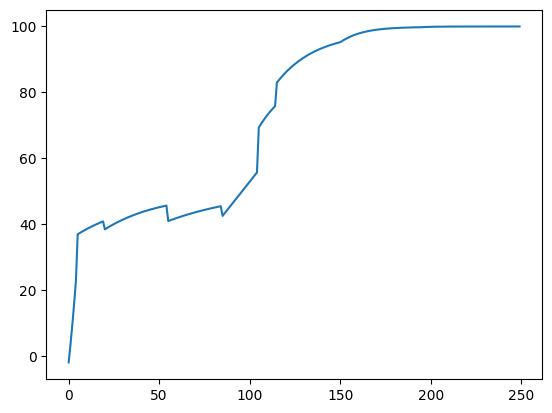

4849.1513218397395
4880.714940681857
1919.0309479629327


In [6]:
plt.plot(accuracies)
plt.show()

print(np.sum(t))
print(np.sum(y_hat[-1, :, :]))
print(np.sum(y_hat[1, :, :]))

In [7]:
print(accuracies[-1])

99.98035837134928


In [8]:
hh.close()
file_path = r"C:\Users\yda2\Downloads\projects\master_project\model\results\model_2\final\data.h5"
with h5py.File(file_path, "r+") as f:
    f.create_dataset("accuracy", data=accuracies)


In [12]:
file_path = r"C:\Users\yda2\Downloads\projects\master_project\model\results\model_2\final\data.h5"
hh = h5py.File(file_path, "r")
print(hh.keys())
hh.close()

<KeysViewHDF5 ['accuracy', 'cost', 'ind', 'target', 'time', 'y_hat']>
